# Exploratory Data Analysis

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from pathlib import Path

## Read Cleaned Data

From the data cleaning notebook, there are two different files:
1. `annual_aqi_clean.csv` is annual summary data from the EPA's AirData system
2. `aqs_by_county_clean.csv` is sensor data that was collected via the EPA's AQS API

The annual summary data will contain more information on the number of days in various areas such as days with AQI measureed, good, moderate, unhealthy, very unhealthy, and hazardous air quality.  There are also columns concerning specific pollutant measurements like pm2.5, pm10, and ozone.

The AQS data is also annual summary data, but on a measured pollutant basis.  So it contains values for measurements of specific pollutants in counties for the year.

In [2]:
# Annual AQI summary data
aqi = pd.read_csv('data/annual_aqi_clean.csv')

# AQS sensor data collected via API
aqs = pd.read_csv('data/aqs_by_county_clean.csv')

## AQI Annual Summary EDA

In this section, we'll be looking at the AQI data, which is summary day count information on a year and county basis.

Some sources to help understand the following pollutants and data:
* Particulate Matter (PM10, PM2.5): https://www.epa.gov/pm-pollution
* Ground Level Ozone (Ozone): https://www.epa.gov/ground-level-ozone-pollution
* Carbon Monoxide (CO): https://www.epa.gov/co-pollution
* Nitrogen Dioxide (NO2): https://www.epa.gov/no2-pollution

In [3]:
aqi.head()

,state,county,year,days_with_aqi,good_days,mod_days,uh_sens_days,uh_days,v_uh_days,haz_days,...,days_pm2.5,days_pm10,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate
0,california,alameda,2009,365,190,162,12,1,0,0,...,234,0,1136.0,1980.992,34.260,17700.0,3314.900,38.817,0.064,0
1,california,butte,2009,365,185,148,31,1,0,0,...,101,0,90.0,1963.467,33.809,1907.0,3390.433,38.850,0.047,0
2,california,contra costa,2009,365,274,84,6,1,0,0,...,78,0,669.0,2002.323,34.283,10976.0,3330.618,38.823,0.061,0
3,california,el dorado,2009,362,240,82,33,7,0,0,...,2,1,88.0,1981.477,34.511,1410.0,3330.952,38.821,0.062,0
4,california,fresno,2009,365,109,140,80,36,0,0,...,129,0,1068.0,1959.166,33.788,14117.0,3271.289,38.489,0.076,0


In [4]:
aqi.shape

(4635, 26)

In [5]:
aqi.columns

Index(['state', 'county', 'year', 'days_with_aqi', 'good_days', 'mod_days',
       'uh_sens_days', 'uh_days', 'v_uh_days', 'haz_days', 'max_aqi',
       '90_per_aqi', 'median_aqi', 'days_co', 'days_no2', 'days_ozone',
       'days_pm2.5', 'days_pm10', 'births_low', 'avg_weight_low',
       'avg_ges_age_low', 'births_all', 'avg_weight_all', 'avg_ges_age_all',
       'pct_low', 'high_rate'],
      dtype='object')

In [6]:
aqi.dtypes

state               object
county              object
year                 int64
days_with_aqi        int64
good_days            int64
mod_days             int64
uh_sens_days         int64
uh_days              int64
v_uh_days            int64
haz_days             int64
max_aqi              int64
90_per_aqi           int64
median_aqi           int64
days_co              int64
days_no2             int64
days_ozone           int64
days_pm2.5           int64
days_pm10            int64
births_low         float64
avg_weight_low     float64
avg_ges_age_low    float64
births_all         float64
avg_weight_all     float64
avg_ges_age_all    float64
pct_low            float64
high_rate            int64
dtype: object

In [7]:
aqi['year'].sort_values().unique()

array([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020])

### Filter Data

The EPA generally uses 75% as a number of observations to ensure relevancy.  So we'll filter the aqi data to only look at records where `days_with_aqi` is greater than 75% of the days in a year.

In [8]:
aqi = aqi[aqi['days_with_aqi'] > (365 * .75)]

### Air Quality Index (AQI) Day Count

From the EPA:

Each category corresponds to a different level of health concern. The six levels of health concern and what they mean are:
* **"Good"** AQI is 0 - 50. Air quality is considered satisfactory, and air pollution poses little or no risk.
* **"Moderate"** AQI is 51 - 100. Air quality is acceptable; however, for some pollutants there may be a moderate health concern for a very small number of people. For example, people who are unusually sensitive to ozone may experience respiratory symptoms.
* **"Unhealthy for Sensitive Groups"** AQI is 101 - 150. Although general public is not likely to be affected at this AQI range, people with lung disease, older adults and children are at a greater risk from exposure to ozone, whereas persons with heart and lung disease, older adults and children are at greater risk from the presence of particles in the air.
* **"Unhealthy"** AQI is 151 - 200. Everyone may begin to experience some adverse health effects, and members of the sensitive groups may experience more serious effects.
* **"Very Unhealthy"** AQI is 201 - 300. This would trigger a health alert signifying that everyone may experience more serious health effects.
* **"Hazardous"** AQI greater than 300. This would trigger health warnings of emergency conditions. The entire population is more likely to be affected.

[source](https://www.epa.gov/outdoor-air-quality-data/air-data-basic-information#other)

In [9]:
aqi[[col for col in aqi.columns if col.find('_days') != -1]].describe()

,good_days,mod_days,uh_sens_days,uh_days,v_uh_days,haz_days
count,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000
mean,258.318776,91.740933,8.193190,1.767580,0.182087,0.052800
std,65.911144,54.021439,16.113551,6.721601,1.625441,0.597523
min,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,225.000000,50.000000,0.000000,0.000000,0.000000,0.000000
50%,272.000000,82.000000,2.000000,0.000000,0.000000,0.000000
75%,307.000000,125.000000,8.000000,1.000000,0.000000,0.000000
max,365.000000,339.000000,122.000000,74.000000,74.000000,18.000000


When looking through these descriptive statistics for all of the day counts for the general air quality, most of the days are concentrated in good and moderate.  Unhealthy, very unhealthy, and hazardous are largely absent--even the 75th percentile values for all of those categories is 0, so very few locations had many days with that type of air quality.

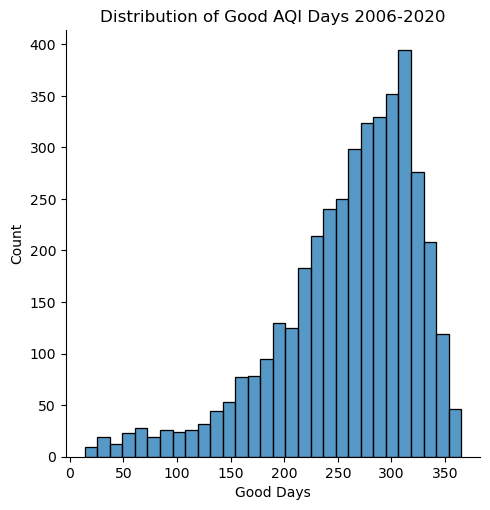

In [10]:
sns.displot(data=aqi,
            x='good_days',
            kind='hist',
            bins=30).set(xlabel='Good Days',
                         title='Distribution of Good AQI Days 2006-2020');

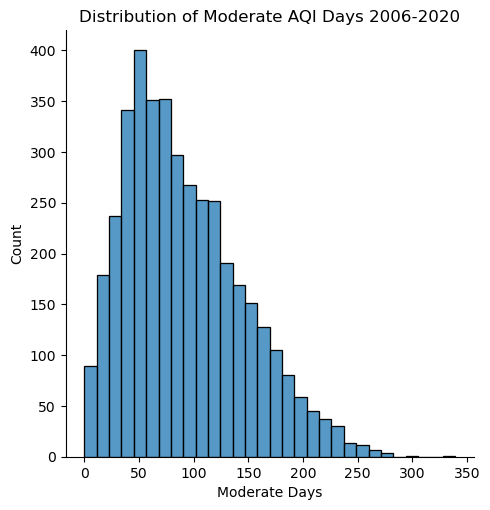

In [11]:
sns.displot(data=aqi,
            x='mod_days',
            kind='hist',
            bins=30).set(xlabel='Moderate Days',
                         title='Distribution of Moderate AQI Days 2006-2020');

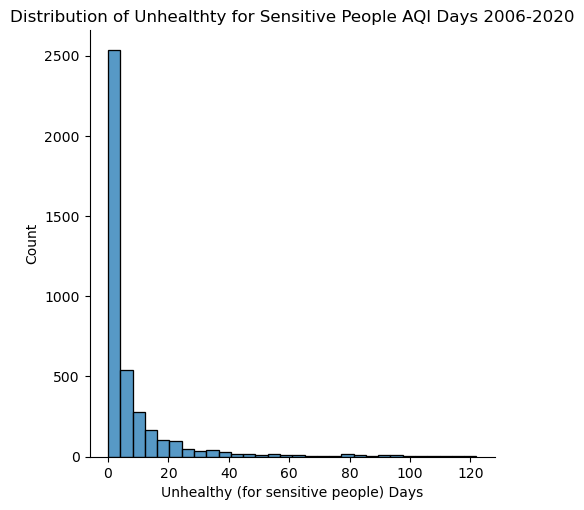

In [12]:
sns.displot(data=aqi,
            x='uh_sens_days',
            kind='hist',
            bins=30).set(xlabel='Unhealthy (for sensitive people) Days',
                         title='Distribution of Unhealthty for Sensitive People AQI Days 2006-2020');

Overall, looking at these distributions gives an idea that the data is has mostly good and moderate day counts, and most categories beyond that have very few records.

### Pollutant Specific Day Count

When looking at the `days_[pollutant]` columns, those represent which pollutant was the most prevalent for each `days_with_aqi` meaning that the counts of the 4 pollutant days equals the `days_with_aqi`

In [13]:
aqi[[col for col in aqi.columns if col.find('days_') != -1]].describe()

,days_with_aqi,days_co,days_no2,days_ozone,days_pm2.5,days_pm10
count,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000
mean,360.255366,0.899087,9.765606,195.551443,146.970392,7.068838
std,13.702277,7.450258,25.284352,97.780622,97.245154,26.588710
min,275.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,362.000000,0.000000,0.000000,140.000000,71.000000,0.000000
50%,365.000000,0.000000,0.000000,199.000000,146.000000,0.000000
75%,365.000000,0.000000,6.000000,254.000000,207.000000,1.000000
max,366.000000,131.000000,300.000000,366.000000,366.000000,346.000000


The values all look reasonable, since these columns all represent the count of days in a year. 

Check to see top 10 observations for each pollutant (count of days where pollutant was the main pollutant)

#### Days PM10

PM10: Particulate Matter; inhalable particles, with diameters that are generally 10 micrometers and smaller;

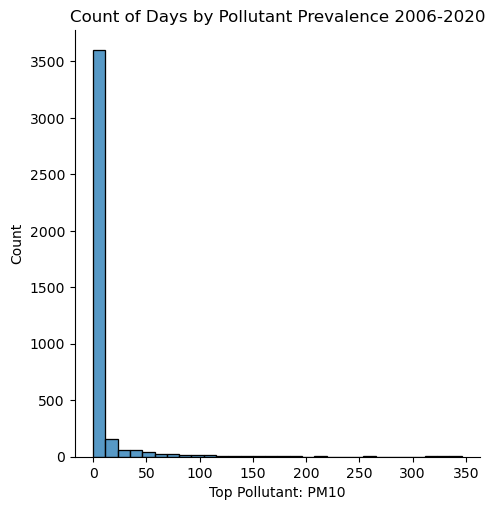

In [124]:
sns.displot(aqi,
            x='days_pm10',
            kind='hist',
            bins=30).set(xlabel='Top Pollutant: PM10',
                         title='Count of Days by Pollutant Prevalence 2006-2020');

In [120]:
aqi[
    ['state', 'county', 'year', 'pct_low', 'high_rate', 'days_pm10']
].sort_values(by='days_pm10', ascending=False).head(10)

,state,county,year,pct_low,high_rate,days_pm10
1562,arizona,mohave,2014,0.060,0,346
1150,arizona,mohave,2019,0.066,0,337
189,arizona,mohave,2020,0.052,0,333
738,arizona,mohave,2018,0.051,0,330
2346,arizona,mohave,2017,0.045,0,323
2757,arizona,mohave,2016,0.056,0,323
1942,arizona,mohave,2015,0.054,0,323
1660,idaho,canyon,2014,0.047,0,319
3605,arizona,mohave,2013,0.057,0,316
3198,colorado,mesa,2006,0.060,0,274


#### Days PM2.5

PM2.5: Particulate Matter; fine inhalable particles, with diameters that are generally 2.5 micrometers and smaller.

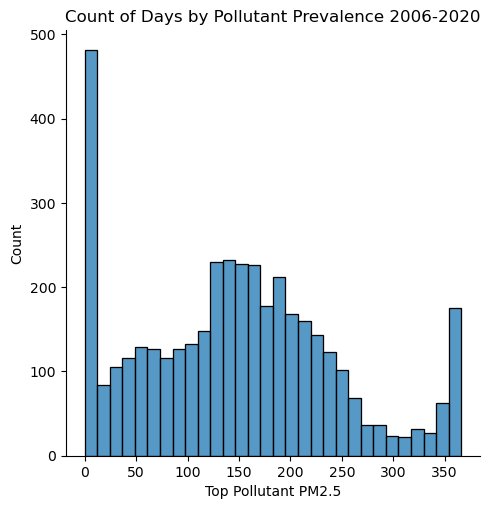

In [122]:
sns.displot(aqi,
            x='days_pm2.5',
            kind='hist',
            bins=30).set(xlabel='Top Pollutant: PM2.5',
                         title='Count of Days by Pollutant Prevalence 2006-2020');

In [125]:
aqi[
    ['state', 'county', 'year', 'pct_low', 'high_rate', 'days_pm2.5']
].sort_values(by='days_pm2.5', ascending=False).head(10)

,state,county,year,pct_low,high_rate,days_pm2.5
320,iowa,black hawk,2020,0.078,0,366
508,oregon,linn,2020,0.047,0,366
2855,hawaii,hawaii,2016,0.081,0,366
3535,oregon,linn,2012,0.048,0,366
3395,iowa,johnson,2012,0.057,0,366
3545,texas,ector,2012,0.076,0,366
288,hawaii,hawaii,2020,0.077,0,366
3076,oregon,linn,2016,0.032,0,366
3136,washington,snohomish,2016,0.047,0,366
711,texas,ector,2008,0.092,1,366


#### Days Ozone
Ground-level Ozone: Ozone at ground level is a harmful air pollutant, because of its effects on people and the environment, and it is the main ingredient in “smog."
[source](https://www.epa.gov/ground-level-ozone-pollution/ground-level-ozone-basics#effects)

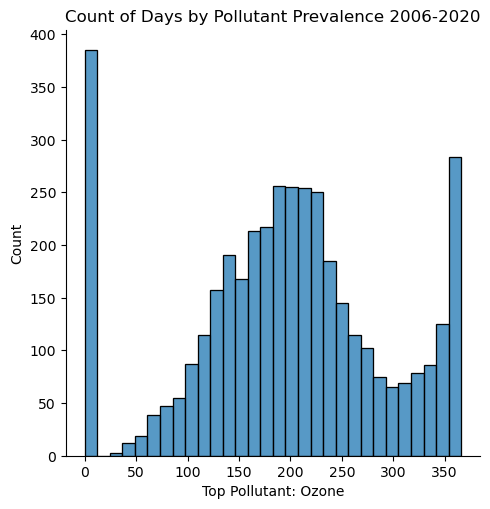

In [128]:
sns.displot(aqi,
            x='days_ozone',
            kind='hist',
            bins=30).set(xlabel='Top Pollutant: Ozone',
                         title='Count of Days by Pollutant Prevalence 2006-2020');

In [126]:
aqi[
    ['state', 'county', 'year', 'pct_low', 'high_rate', 'days_ozone']
].sort_values(by='days_ozone', ascending=False).head(10)

,state,county,year,pct_low,high_rate,days_ozone
256,florida,manatee,2020,0.067,0,366
3325,colorado,jefferson,2012,0.076,0,366
237,colorado,jefferson,2020,0.076,0,366
3348,florida,pasco,2012,0.062,0,366
3344,florida,okaloosa,2012,0.057,0,366
3340,florida,manatee,2012,0.058,0,366
2805,colorado,jefferson,2016,0.068,0,366
2821,florida,manatee,2016,0.064,0,366
2827,florida,osceola,2016,0.072,0,366
2829,florida,pasco,2016,0.065,0,366


#### Days CO
Carbon monoxide: CO is a colorless, odorless gas that can be harmful when inhaled in large amounts. CO is released when something is burned. The greatest sources of CO to outdoor air are cars, trucks and other vehicles or machinery that burn fossil fuels.
[source](https://www.epa.gov/co-pollution/basic-information-about-carbon-monoxide-co-outdoor-air-pollution#What%20is%20CO)

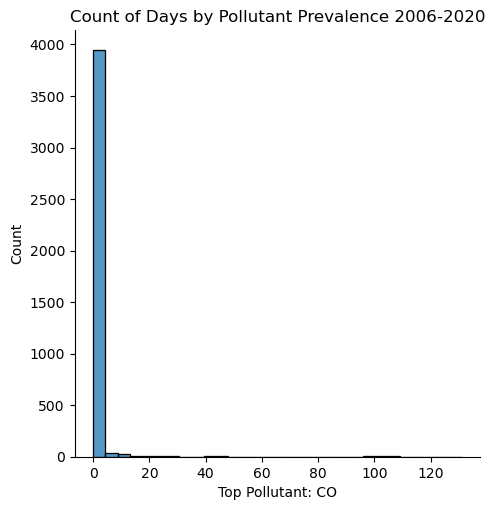

In [129]:
sns.displot(aqi,
            x='days_co',
            kind='hist',
            bins=30).set(xlabel='Top Pollutant: CO',
                         title='Count of Days by Pollutant Prevalence 2006-2020');

In [127]:
aqi[
    ['state', 'county', 'year', 'pct_low', 'high_rate', 'days_co']
].sort_values(by='days_co', ascending=False).head(10)

,state,county,year,pct_low,high_rate,days_co
654,montana,yellowstone,2008,0.057,0,131
699,ohio,stark,2008,0.063,0,108
3234,new york,niagara,2006,0.052,0,107
4082,ohio,stark,2007,0.068,0,106
1905,virginia,richmond city,2014,0.096,1,103
3262,ohio,montgomery,2006,0.067,0,102
689,ohio,franklin,2008,0.069,0,102
4080,ohio,montgomery,2007,0.067,0,102
3889,ohio,summit,2013,0.069,0,101
4083,ohio,summit,2007,0.060,0,101


#### Days NO2
Nitrogen Dioxide: Nitrogen Dioxide (NO2) is one of a group of highly reactive gases known as oxides of nitrogen or nitrogen oxides (NOx). Other nitrogen oxides include nitrous acid and nitric acid. NO2 is used as the indicator for the larger group of nitrogen oxides. [source](https://www.epa.gov/no2-pollution/basic-information-about-no2#What%20is%20NO2)

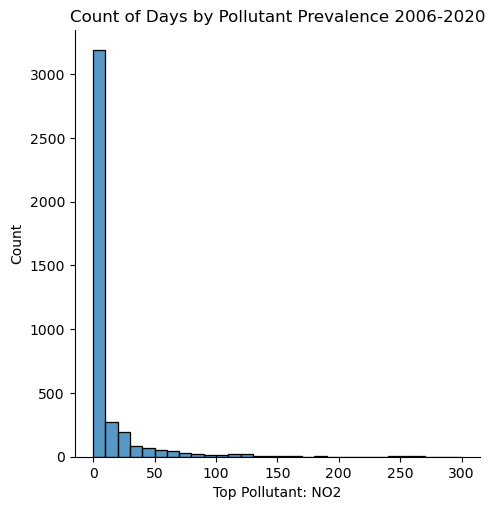

In [131]:
sns.displot(aqi,
            x='days_no2',
            kind='hist',
            bins=30).set(xlabel='Top Pollutant: NO2',
                         title='Count of Days by Pollutant Prevalence 2006-2020');

In [130]:
aqi[
    ['state', 'county', 'year', 'pct_low', 'high_rate', 'days_no2']
].sort_values(by='days_no2', ascending=False).head(10)

,state,county,year,pct_low,high_rate,days_no2
2299,virginia,alexandria city,2015,0.053,0,300
565,virginia,norfolk city,2020,0.089,1,266
1905,virginia,richmond city,2014,0.096,1,262
3233,new york,nassau,2006,0.070,0,262
3128,virginia,norfolk city,2016,0.094,1,255
1109,virginia,norfolk city,2018,0.103,1,254
1903,virginia,norfolk city,2014,0.087,1,249
3941,virginia,norfolk city,2013,0.087,1,247
2715,virginia,norfolk city,2017,0.089,1,244
3563,virginia,alexandria city,2012,0.062,0,182


In each of the sections it was interesting that there were often repeat locations, which may indicate there is some specific cause in that area for particular pollutants to be more elevated than the others.  For example in the Nitrogen Dioxide days count, all but one of the observations are from Virginia, and most are in Norfolk City.  This was also the only pollutant-specific day count area, where when looking at the top 10 observations, there were multiple indicators of high rates of low birthweight.

According to the [EPA](https://www.epa.gov/no2-pollution/basic-information-about-no2), "Nitrogen Dioxide (NO2) is one of a group of highly reactive gases known as oxides of nitrogen or nitrogen oxides (NOx). Other nitrogen oxides include nitrous acid and nitric acid. NO2 is used as the indicator for the larger group of nitrogen oxides.

NO2 primarily gets in the air from the burning of fuel. NO2 forms from emissions from cars, trucks and buses, power plants, and off-road equipment."

So even though there are many days in this area, there is no specific mention about a connection between this pollutant and birthweight.  As far as what contributes to these levels in the Virginia area may be a good topic for future research.

### AQI Median and 90 Percentile Days

These values represent the median AQI and the 90 percentile AQI score for the county for the year reported.

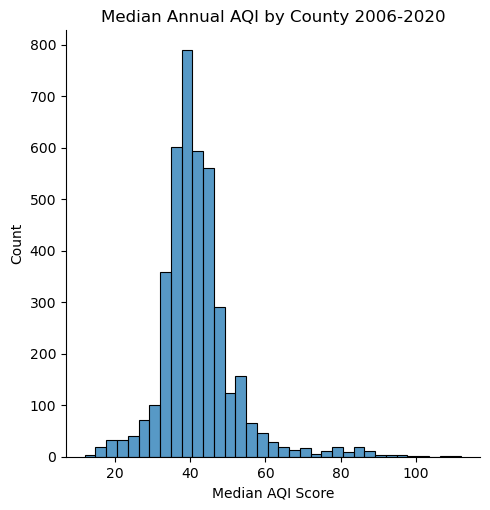

In [133]:
sns.displot(aqi,
            x='median_aqi',
            kind='hist',
            bins=35).set(xlabel='Median AQI Score',
                         title='Median Annual AQI by County 2006-2020');

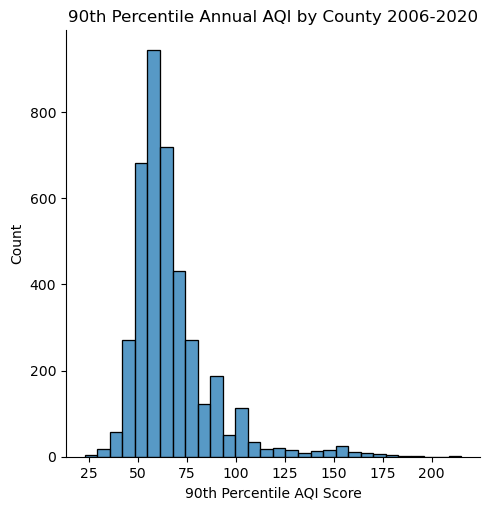

In [134]:
sns.displot(aqi,
            x='90_per_aqi',
            kind='hist',
            bins=30).set(xlabel='90th Percentile AQI Score',
                         title='90th Percentile Annual AQI by County 2006-2020');

### Birth Weight Rate Observations

Let's look a bit at the target data

Observations by low birth weight percentage (highest 10)

In [26]:
aqi.sort_values(by='pct_low', ascending=False).head(10)

,state,county,year,days_with_aqi,good_days,mod_days,uh_sens_days,uh_days,v_uh_days,haz_days,...,days_pm2.5,days_pm10,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate
4496,louisiana,caddo,2010,363,261,91,11,0,0,0,...,60,0,402.0,1977.264,33.945,2986.0,3088.602,37.874,0.135,1
1768,mississippi,hinds,2014,365,180,184,0,1,0,0,...,274,0,363.0,1931.003,33.959,2779.0,3065.051,37.917,0.131,1
4233,louisiana,caddo,2011,365,240,107,18,0,0,0,...,68,0,372.0,1939.624,33.747,2871.0,3099.827,37.870,0.130,1
401,mississippi,hinds,2020,366,249,116,1,0,0,0,...,265,0,290.0,2035.279,34.610,2226.0,3081.211,37.933,0.130,1
287,georgia,richmond,2020,366,268,97,1,0,0,0,...,267,15,262.0,1965.233,34.351,2099.0,3124.365,38.307,0.125,1
2559,mississippi,hinds,2017,365,256,109,0,0,0,0,...,243,0,322.0,1909.012,33.643,2572.0,3069.387,37.916,0.125,1
3445,mississippi,hinds,2012,366,241,122,2,1,0,0,...,249,0,327.0,1986.190,34.217,2668.0,3082.299,37.973,0.123,1
1360,mississippi,hinds,2019,365,256,109,0,0,0,0,...,222,0,290.0,2038.310,34.379,2351.0,3094.378,37.923,0.123,1
2153,mississippi,hinds,2015,365,217,148,0,0,0,0,...,253,0,307.0,1967.857,34.094,2566.0,3085.500,37.993,0.120,1
3938,virginia,hampton city,2013,359,313,44,2,0,0,0,...,181,0,48.0,1738.479,32.729,399.0,3205.329,38.266,0.120,1


Like some of the pollutant day count data, we see that some of the highest low birth weight rates occur in the same county in multiple years.  Most of these counties have a good day count below the mean for the data set and a moderate day count above the mean for the data set.  It will be interesting to see if these day counts can be used for an effective model.

Observations by low birth weight percentage (lowest 10)

In [27]:
aqi.sort_values(by='pct_low', ascending=True).head(10)

,state,county,year,days_with_aqi,good_days,mod_days,uh_sens_days,uh_days,v_uh_days,haz_days,...,days_pm2.5,days_pm10,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate
460,new york,tompkins,2020,364,359,5,0,0,0,0,...,0,0,13.0,2204.077,35.077,530.0,3403.653,39.079,0.025,0
1419,new york,tompkins,2019,356,349,7,0,0,0,0,...,0,0,14.0,2174.000,35.571,510.0,3414.189,39.043,0.027,0
1907,washington,cowlitz,2014,323,309,14,0,0,0,0,...,323,0,24.0,1982.417,34.125,804.0,3443.707,39.232,0.030,0
1467,oregon,linn,2019,365,280,83,2,0,0,0,...,365,0,33.0,2000.636,33.939,1048.0,3498.659,39.032,0.031,0
593,california,humboldt,2008,364,349,15,0,0,0,0,...,50,4,37.0,1884.730,33.556,1168.0,3430.532,38.935,0.032,0
3076,oregon,linn,2016,366,333,33,0,0,0,0,...,366,0,33.0,2068.242,34.424,1027.0,3460.391,39.009,0.032,0
3084,pennsylvania,blair,2016,366,285,79,2,0,0,0,...,166,4,28.0,1989.750,34.143,846.0,3410.701,38.995,0.033,0
2735,wisconsin,la crosse,2017,360,311,49,0,0,0,0,...,166,0,27.0,2059.185,33.889,819.0,3462.660,39.269,0.033,0
2649,ohio,medina,2017,364,292,72,0,0,0,0,...,157,0,41.0,2051.732,34.878,1231.0,3438.399,38.957,0.033,0
1478,pennsylvania,centre,2019,365,267,98,0,0,0,0,...,162,0,27.0,2042.370,34.296,819.0,3428.707,39.076,0.033,0


Although there are some repeat locations on this list, it is more diverse than the locations for the highest rates.  It can be seen here that the good days count far exceed the moderate day count.

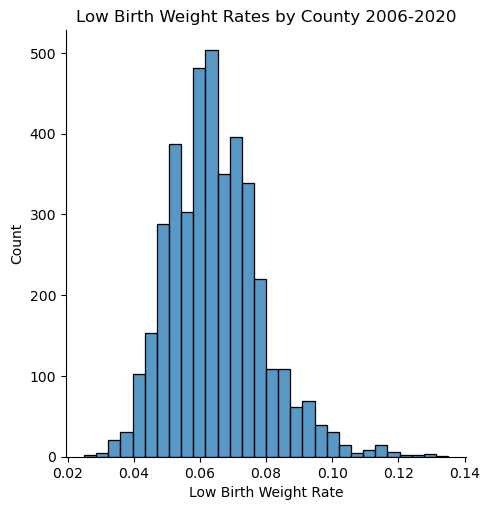

In [135]:
sns.displot(aqi,
            x='pct_low',
            kind='hist',
            bins=30).set(xlabel='Low Birth Weight Rate',
                         title='Low Birth Weight Rates by County 2006-2020');

During data collection and cleaning, a high rate feature was created that classifies the rate for the county as "high" if the rate for the year exceeds the current national mean rate of 8.24%.  In the cleaned and now filtered data, let us look at the balance between the classes.

In [136]:
aqi['high_rate'].value_counts(normalize=True)

0    0.902048
1    0.097952
Name: high_rate, dtype: float64

This is a very unbalanced class and will be a challenge to model.  Let's take a look at a correlation heatmap to see if any particular features appear correlated with the low birth weight rate or classification:

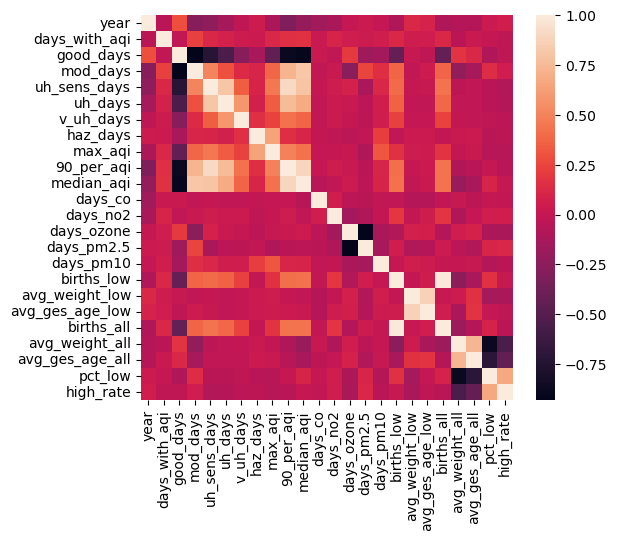

In [147]:
plt.figure(figsize=(6, 5))
sns.heatmap(aqi.corr(numeric_only=True));

Here we don't see any particularly strong positive correlations between `pct_low` or `high_rate` and many other features.  It does appear there is slightly positive correlation with the features `mod_days`, `median_aqi`, `days_no2`, and `days_pm2.5`.  And a slightly negative correlation with `good_days`, `days_ozone`, and `days_pm10`

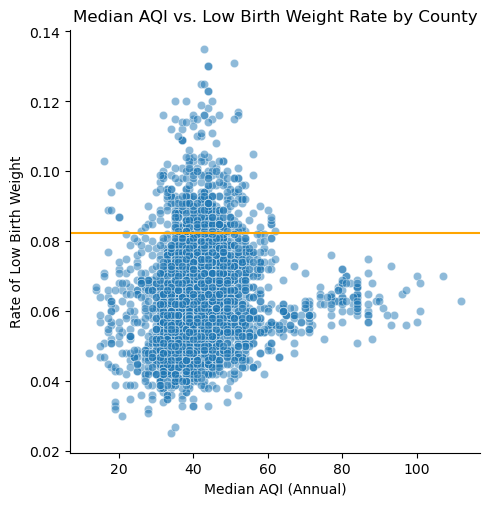

In [153]:
sns.relplot(aqi, 
            x='median_aqi', 
            y='pct_low',
            alpha=0.5).set(title='Median AQI vs. Low Birth Weight Rate by County',
                             xlabel='Median AQI (Annual)',
                             ylabel='Rate of Low Birth Weight')

# add line for national mean and divider for 'high rate'
plt.axhline(.0824, color='orange');

There doesn't appear to be any obvious correlation here.  You can also see some of the imbalance of the class when you see how many data points are below the national average.

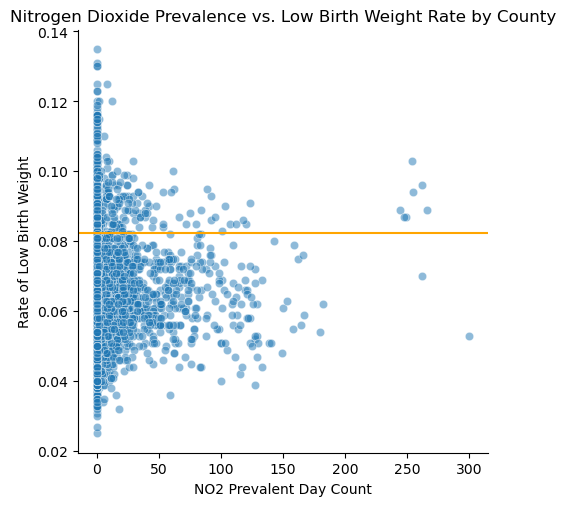

In [155]:
sns.relplot(aqi, 
            x='days_no2', 
            y='pct_low',
            alpha=0.5).set(title='Nitrogen Dioxide Prevalence vs. Low Birth Weight Rate by County',
                             xlabel='NO2 Prevalent Day Count',
                             ylabel='Rate of Low Birth Weight')

# add line for national mean and divider for 'high rate'
plt.axhline(.0824, color='orange');

There also doesn't seem to be any strong correlation that appears when plotting this data.  As we saw in the earlier distributions, we see a high concentration 0 day counts, but there are still many high rate observations.  At the same time, there are many 0 day counts with below average rate observations.

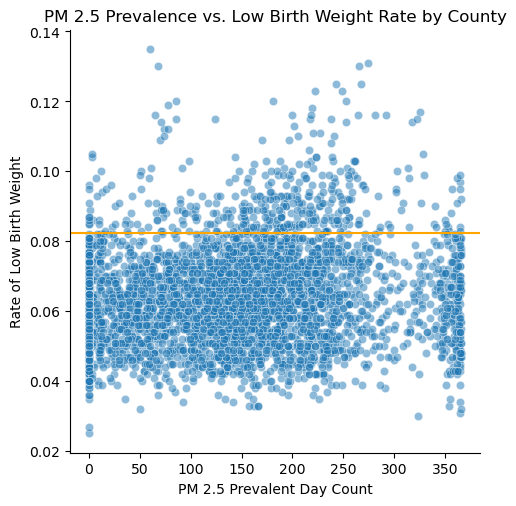

In [159]:
sns.relplot(aqi, 
            x='days_pm2.5', 
            y='pct_low',
            alpha=0.5).set(title='PM 2.5 Prevalence vs. Low Birth Weight Rate by County',
                             xlabel='PM 2.5 Prevalent Day Count',
                             ylabel='Rate of Low Birth Weight')

# add line for national mean and divider for 'high rate'
plt.axhline(.0824, color='orange');

There doesn't appear to be any obvious correlation here.  This is another instance where some of the imbalance of the class becomes more clear.

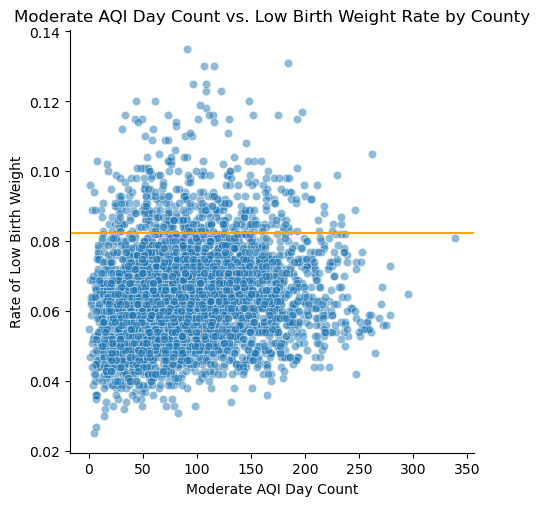

In [158]:
sns.relplot(aqi, 
            x='mod_days', 
            y='pct_low',
            alpha=0.5).set(title='Moderate AQI Day Count vs. Low Birth Weight Rate by County',
                             xlabel='Moderate AQI Day Count',
                             ylabel='Rate of Low Birth Weight')

# add line for national mean and divider for 'high rate'
plt.axhline(.0824, color='orange');

The shape of this plot almost looks conic, which is interesting.  It does have a very slight positive shape, but it is not obvious.

# EDA - AQS Data

## First looking at (mostly) raw data

In [2]:
data_path = Path('data/aqs_county_files/')


aqs_dfs = [
    pd.read_csv(file) for file in data_path.glob('AQS_county*') if file.is_file()
]

aqs = pd.concat(aqs_dfs)

In [3]:
aqs = aqs[aqs['validity_indicator']=='Y']

In [4]:
aqs.shape

(273633, 57)

In [5]:
drop = ['state_code',
 'county_code',
 'site_number',
 'parameter_code',
 'poc',
 'latitude',
 'longitude',
 'city', 'cbsa_code', 'cbsa', 'date_of_last_change',
 'first_max_value',
  'first_max_datetime',
  'second_max_value',
  'second_max_datetime',
  'third_max_value',
  'third_max_datetime',
  'fourth_max_value',
  'fourth_max_datetime',
  'first_max_nonoverlap_value',
  'first_max_n_o_datetime',
  'second_max_nonoverlap_value',
  'second_max_n_o_datetime',
  'ninety_ninth_percentile',
  'ninety_eighth_percentile',
  'ninety_fifth_percentile',
  'ninetieth_percentile',
  'seventy_fifth_percentile',
  'fiftieth_percentile',
  'tenth_percentile',
  'local_site_name',
  'site_address',
 'datum',
 'units_of_measure',
 'sample_duration',
 'secondary_exceedance_count',
 'pollutant_standard',
 'metric_used',
 'method',
 'event_type',
 'observation_count',
 'observation_percent',
 'required_day_count',
 'exceptional_data_count',
 'null_observation_count']

In [6]:
aqs.drop(columns=drop, inplace=True)

In [7]:
aqs.columns

Index(['parameter', 'sample_duration_code', 'year', 'validity_indicator',
       'valid_day_count', 'primary_exceedance_count',
       'certification_indicator', 'arithmetic_mean', 'standard_deviation',
       'state', 'county', 'Unnamed: 0'],
      dtype='object')

In [8]:
aqs['county'].unique().shape

(882,)

In [9]:
aqs['parameter'].value_counts()

PM2.5 - Local Conditions    114892
Ozone                        85983
Sulfur dioxide               28093
PM10 Total 0-10um STP        20520
Nitrogen dioxide (NO2)       11472
Carbon monoxide              10581
Lead (TSP) LC                 1959
Lead PM10 LC FRM/FEM           133
Name: parameter, dtype: int64

#### Far too few entries for the lead data, so will drop those columns after the following pivot

In [10]:
aqs = pd.pivot_table(aqs, values="arithmetic_mean", 
                       index=["state", "county", "year"], 
                       columns=["parameter"],
                       aggfunc='max').reset_index()

In [12]:
aqs.columns

Index(['state', 'county', 'year', 'Carbon monoxide', 'Lead (TSP) LC',
       'Lead PM10 LC FRM/FEM', 'Nitrogen dioxide (NO2)', 'Ozone',
       'PM10 Total 0-10um STP', 'PM2.5 - Local Conditions', 'Sulfur dioxide'],
      dtype='object', name='parameter')

In [13]:
aqs.drop(columns=['Lead (TSP) LC', 'Lead PM10 LC FRM/FEM', 'Sulfur dioxide'], inplace=True)

#### Going to standardize the parameters since some have different units

In [14]:
params = ['Carbon monoxide', 'Nitrogen dioxide (NO2)',
       'Ozone', 'PM10 Total 0-10um STP', 'PM2.5 - Local Conditions']

In [15]:
cte = ColumnTransformer([
    ('ss', StandardScaler(), params)
], remainder='passthrough', verbose_feature_names_out=False)

aqs_ss = cte.fit_transform(aqs)
aqs_ss = pd.DataFrame(aqs_ss, columns=cte.get_feature_names_out())
aqs_ss

,Carbon monoxide,Nitrogen dioxide (NO2),Ozone,PM10 Total 0-10um STP,PM2.5 - Local Conditions,state,county,year
0,NaN,NaN,1.408927,NaN,NaN,Alabama,Baldwin,2006
1,NaN,NaN,0.786863,NaN,0.451867,Alabama,Baldwin,2007
2,NaN,NaN,-0.559256,NaN,NaN,Alabama,Baldwin,2008
3,NaN,NaN,-0.974518,NaN,NaN,Alabama,Baldwin,2009
4,NaN,NaN,0.404271,NaN,0.378846,Alabama,Baldwin,2010
...,...,...,...,...,...,...,...,...
15425,NaN,NaN,0.144567,NaN,NaN,Wyoming,Weston,2017
15426,NaN,NaN,0.348881,NaN,NaN,Wyoming,Weston,2018
15427,NaN,NaN,0.056672,NaN,NaN,Wyoming,Weston,2019
15428,NaN,NaN,0.086191,NaN,NaN,Wyoming,Weston,2020


#### Defining function to look at pollutants across the years for particular counties

In [18]:
def plot_county_pollutants(data, county_state):
    params = ['Carbon monoxide', 'Nitrogen dioxide (NO2)',
               'Ozone', 'PM10 Total 0-10um STP', 'PM2.5 - Local Conditions']

    for county, state in county_state:
        data[(data['county']==county)&(data['state']==state)].plot\
                (x='year', y=params,
                 figsize=(10,10),
                 title=f'{county} County, {state}');
        plt.show()
    return None

#### Starting with Hinds, Mississippi since it had the highest rate of LBW

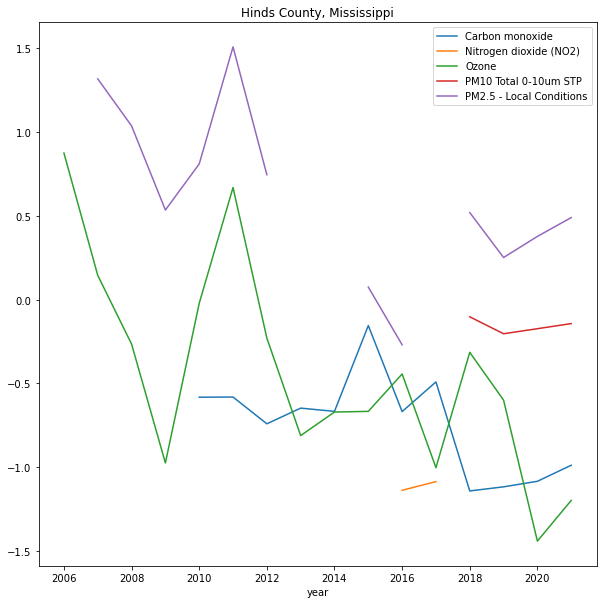

In [19]:
plot_county_pollutants(aqs_ss, [['Hinds', 'Mississippi']])

#### Sadly can see the impact of spotty data here, only three usable years

In [20]:
aqs_ss[['county','state']].sample(10).values

array([['Boone', 'Missouri'],
       ['Saline', 'Kansas'],
       ['Perry', 'Kentucky'],
       ['Meade', 'South Dakota'],
       ['Martin', 'North Carolina'],
       ['McLennan', 'Texas'],
       ['Yavapai', 'Arizona'],
       ['Frederick', 'Virginia'],
       ['Sacramento', 'California'],
       ['Clay', 'Missouri']], dtype=object)

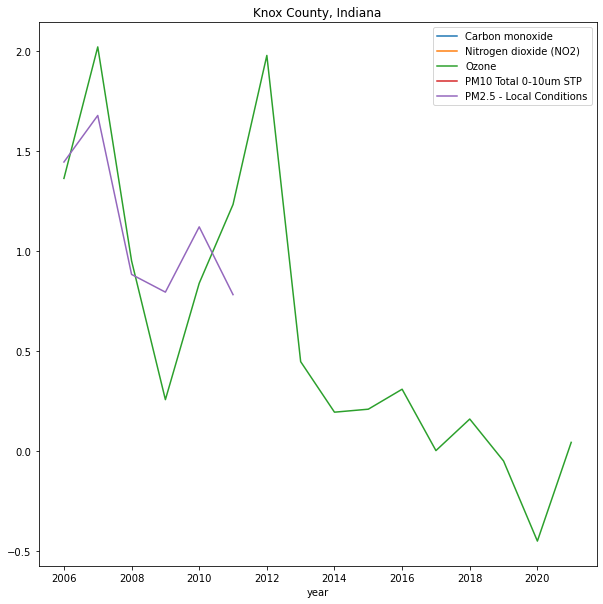

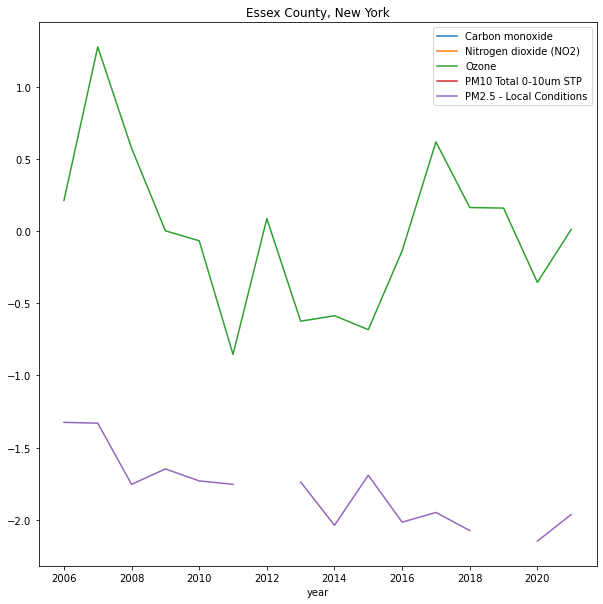

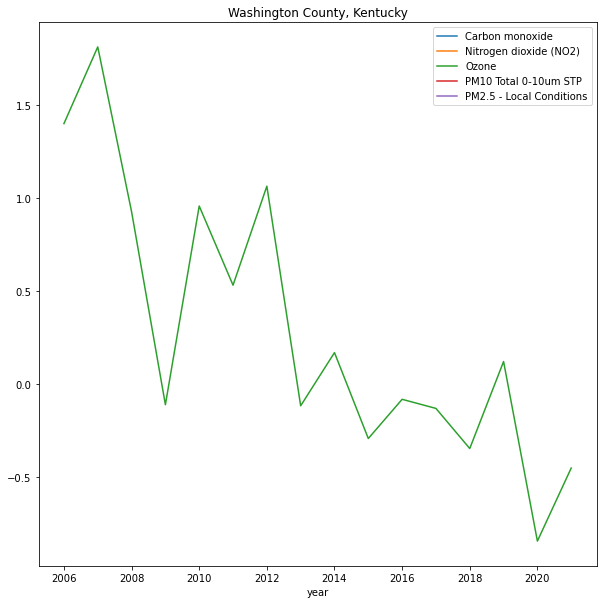

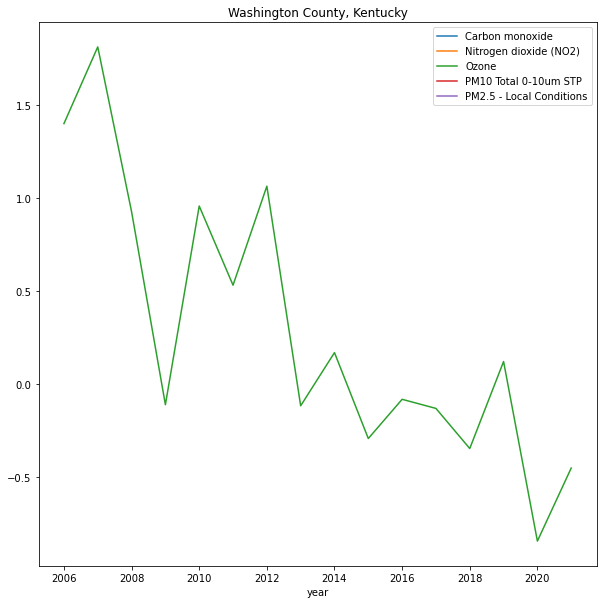

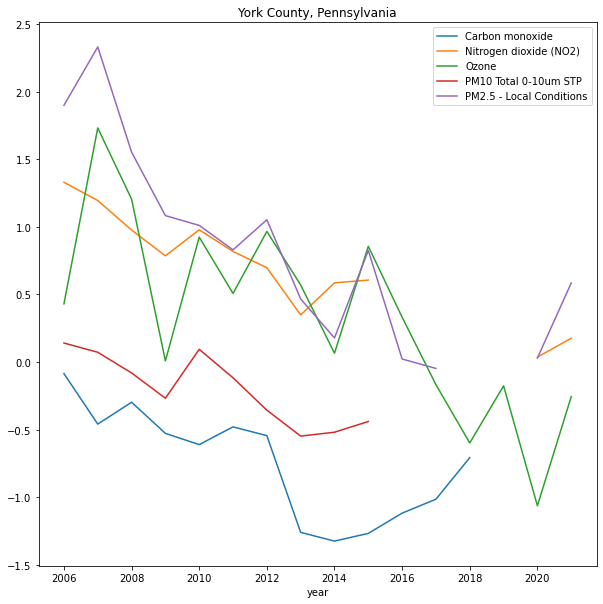

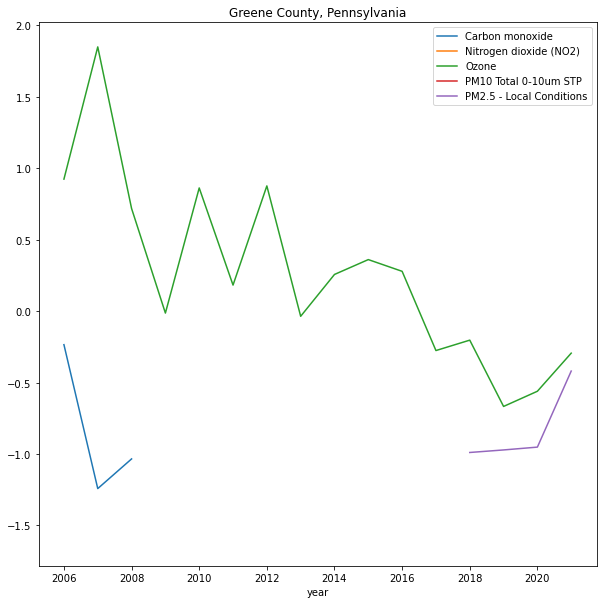

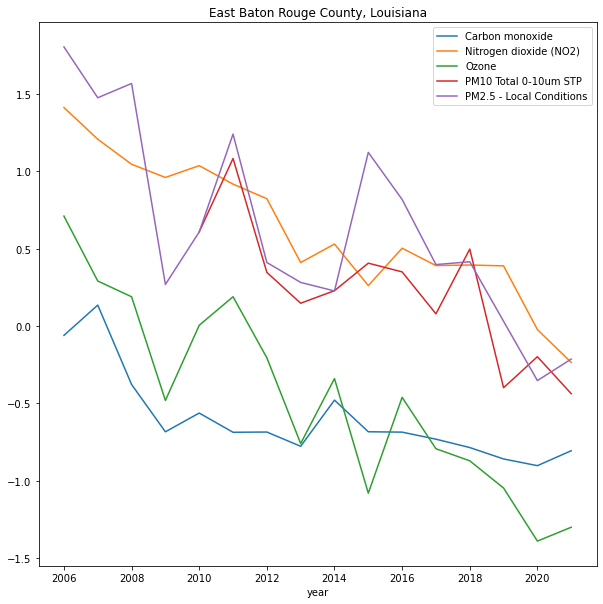

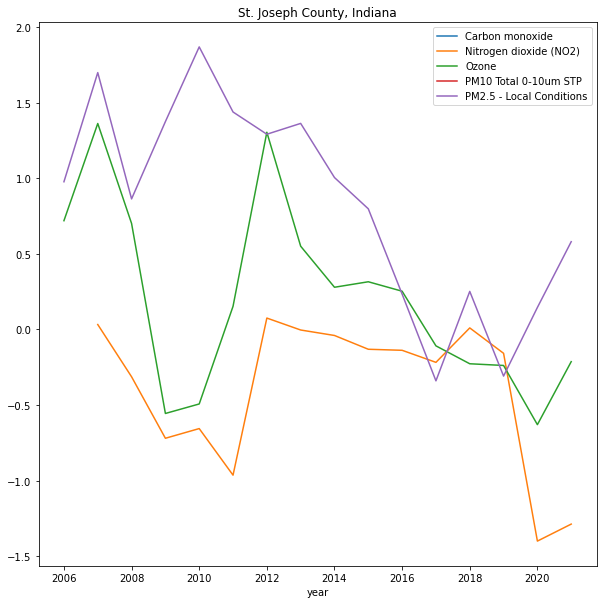

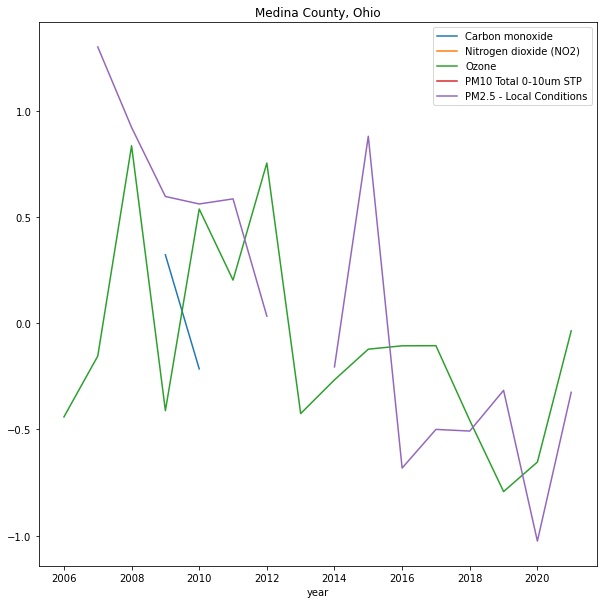

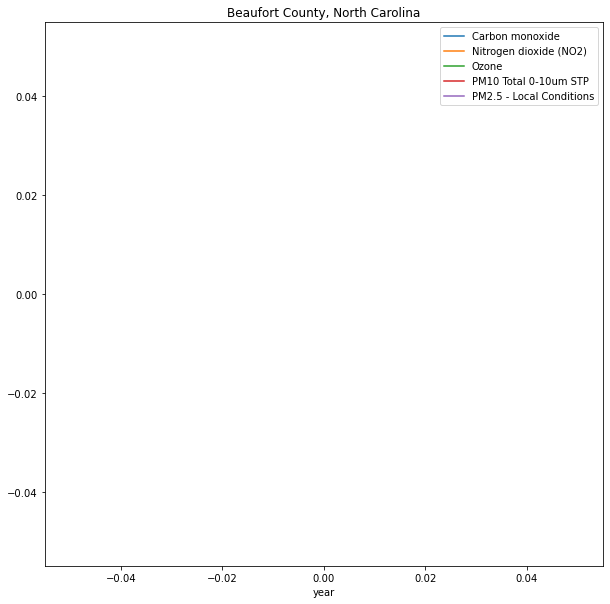

In [21]:
plot_county_pollutants(aqs_ss, aqs_ss[['county','state']].sample(10).values)

#### Quite the spread in availability of data, can see how we lost more than 90% of the entries present in this set.

## Read Cleaned Data

As described earlier, the AQS data contains annual summary data based of measured pollutants. CDC information regarding birth weight is also included, and relationships will be examined below.

In [23]:
# AQS sensor data collected via API
file_path = 'data/aqs_by_county_clean.csv'
aqs = pd.read_csv(file_path)

## Preliminary EDA - General

In [24]:
aqs.head() 

,state,county,year,Carbon monoxide,Nitrogen dioxide (NO2),Ozone,PM10 Total 0-10um STP,PM2.5 - Local Conditions,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate
0,alabama,jefferson,2014,0.578752,28.600838,0.048302,24.918033,11.698347,687.0,1940.866,34.068,7376.0,3216.859,38.508,0.093,1
1,alabama,jefferson,2015,0.526681,22.163818,0.047164,23.883333,11.772881,681.0,1903.761,33.633,7032.0,3210.182,38.434,0.097,1
2,alabama,jefferson,2016,0.444555,28.544643,0.051325,24.256809,10.781667,709.0,1947.176,34.059,7061.0,3188.066,38.456,0.100,1
3,alabama,jefferson,2017,0.367024,20.712610,0.045971,22.300057,10.325455,662.0,1929.279,34.045,6767.0,3202.834,38.456,0.098,1
4,alabama,jefferson,2018,0.344179,23.718644,0.049131,22.985533,10.329508,570.0,1959.763,34.040,6560.0,3222.885,38.468,0.087,1


In [25]:
aqs.shape 

(1012, 16)

In [26]:
aqs.columns

Index(['state', 'county', 'year', 'Carbon monoxide', 'Nitrogen dioxide (NO2)',
       'Ozone', 'PM10 Total 0-10um STP', 'PM2.5 - Local Conditions',
       'births_low', 'avg_weight_low', 'avg_ges_age_low', 'births_all',
       'avg_weight_all', 'avg_ges_age_all', 'pct_low', 'high_rate'],
      dtype='object')

In [27]:
aqs.dtypes

state                        object
county                       object
year                          int64
Carbon monoxide             float64
Nitrogen dioxide (NO2)      float64
Ozone                       float64
PM10 Total 0-10um STP       float64
PM2.5 - Local Conditions    float64
births_low                  float64
avg_weight_low              float64
avg_ges_age_low             float64
births_all                  float64
avg_weight_all              float64
avg_ges_age_all             float64
pct_low                     float64
high_rate                     int64
dtype: object

In [28]:
aqs['year'].sort_values().unique()

array([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020])

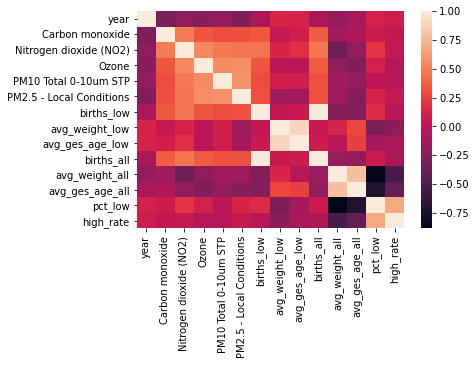

In [29]:
sns.heatmap(data=aqs.corr());

In [30]:
aqs.corr()

,year,Carbon monoxide,Nitrogen dioxide (NO2),Ozone,PM10 Total 0-10um STP,PM2.5 - Local Conditions,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate
year,1.000000,-0.284783,-0.205441,-0.235268,-0.190889,-0.271658,-0.079514,0.123315,0.116481,-0.088985,-0.181950,-0.097625,0.109230,0.067711
Carbon monoxide,-0.284783,1.000000,0.481558,0.335530,0.299211,0.302716,0.338543,0.041591,0.092333,0.355429,-0.131400,-0.065774,0.060382,0.019335
Nitrogen dioxide (NO2),-0.205441,0.481558,1.000000,0.532001,0.474691,0.459212,0.454067,0.122450,0.181509,0.457457,-0.348011,-0.190047,0.197803,0.033822
Ozone,-0.235268,0.335530,0.532001,1.000000,0.544358,0.552741,0.331060,-0.026980,-0.023345,0.352714,-0.206653,-0.276291,0.095332,-0.046305
PM10 Total 0-10um STP,-0.190889,0.299211,0.474691,0.544358,1.000000,0.578793,0.294027,0.091527,0.077573,0.308981,-0.127996,-0.178670,-0.007476,-0.047248
PM2.5 - Local Conditions,-0.271658,0.302716,0.459212,0.552741,0.578793,1.000000,0.311393,-0.133663,-0.111606,0.311609,-0.144439,-0.251139,0.122329,0.041465
births_low,-0.079514,0.338543,0.454067,0.331060,0.294027,0.311393,1.000000,0.016767,0.048745,0.989104,-0.254790,-0.256522,0.153893,-0.026109
avg_weight_low,0.123315,0.041591,0.122450,-0.026980,0.091527,-0.133663,0.016767,1.000000,0.895485,0.048606,0.125803,0.272415,-0.296743,-0.222018
avg_ges_age_low,0.116481,0.092333,0.181509,-0.023345,0.077573,-0.111606,0.048745,0.895485,1.000000,0.063157,-0.032544,0.249129,-0.117991,-0.101451
births_all,-0.088985,0.355429,0.457457,0.352714,0.308981,0.311609,0.989104,0.048606,0.063157,1.000000,-0.173957,-0.186392,0.057048,-0.089851


In [31]:
aqs.pct_low.mean() #calculates mean percentage of total births that are low birth weight for this dataset

0.06677667984189732

In [32]:
aqs.pct_low.median() #calculates median percentage of total births that are low birth weight for this dataset

0.066

### Discussion

The correlation between the individual pollutants and the high rate of low birth rate ranges from -0.0472 and 0.0677, which is not suggestive of strong correlation. However, in combination, there may be a stronger correlation. This will be examined through EDA in this section.

*Additionally, it may be important to note that this dataset, which excludes babies born to mothers with known risk factors such as smoking, has a lower mean percentage of low birth weights (6.7%) than the national average of 8.7%.*

## EDA By Column - Pollutants

It may be of use to observe minimums, maximums, means, and other statistical information for each of the pollutants. These will be examined below.

##### 1. Carbon monoxide

In [18]:
aqs['Carbon monoxide'].describe() #shows a statistical summary of the CO column

count    1012.000000
mean        0.381562
std         0.163689
min         0.043569
25%         0.267306
50%         0.352070
75%         0.468691
max         1.176400
Name: Carbon monoxide, dtype: float64

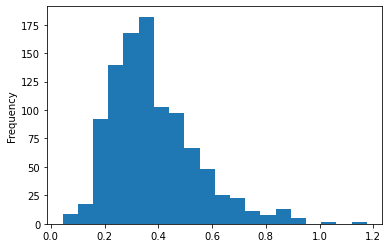

In [34]:
aqs['Carbon monoxide'].plot(kind='hist', bins=20,
                            xlabel='');

#### Cases with lowest CO values

In [20]:
aqs['Carbon monoxide'].nsmallest() #shows the smallest CO values & their respective row numbers

840    0.043569
928    0.050720
927    0.052440
839    0.053953
833    0.067373
Name: Carbon monoxide, dtype: float64

In [21]:
low_co = aqs.iloc[[840, 928, 927, 839, 833]] #creates a dataframe containing rows with the 5 lowest CO values

low_co

,state,county,year,Carbon monoxide,Nitrogen dioxide (NO2),Ozone,PM10 Total 0-10um STP,PM2.5 - Local Conditions,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate
840,pennsylvania,erie,2020,0.043569,12.209169,0.041915,12.514794,6.522519,154.0,2040.617,34.383,1984.0,3267.116,38.383,0.078,0
928,texas,travis,2010,0.050720,6.810979,0.047627,16.949153,10.019298,852.0,2003.412,34.038,13281.0,3312.613,38.687,0.064,0
927,texas,travis,2009,0.052440,6.310294,0.048778,17.711864,10.072881,854.0,1946.509,33.830,13552.0,3313.626,38.654,0.063,0
839,pennsylvania,erie,2019,0.053953,3.955683,0.043456,12.366591,7.538290,133.0,1929.459,33.910,1885.0,3270.604,38.427,0.071,0
833,pennsylvania,cambria,2016,0.067373,15.233429,0.048015,14.779106,8.940451,50.0,1834.540,33.160,848.0,3296.351,38.529,0.059,0


The lowest CO values in the dataset occur in Travis County, TX, Eerie County, PA, and Cambria County PA. 

None of them are in the high rate low birth weight class.

#### Cases with highest CO values

In [23]:
aqs['Carbon monoxide'].nlargest() #shows the largest CO values & their respective row numbers

502    1.176400
119    1.126575
91     1.051252
117    1.014378
764    0.945322
Name: Carbon monoxide, dtype: float64

In [24]:
high_co = aqs.iloc[[502, 119, 91, 117, 764]] #creates a dataframe containing rows with the 5 highest CO values

high_co

,state,county,year,Carbon monoxide,Nitrogen dioxide (NO2),Ozone,PM10 Total 0-10um STP,PM2.5 - Local Conditions,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate
502,indiana,vanderburgh,2011,1.176400,16.639881,0.053841,18.362069,12.264407,104.0,1941.587,33.673,1572.0,3275.976,38.250,0.066,0
119,california,los angeles,2008,1.126575,48.338843,0.063647,44.863337,16.089474,8537.0,1989.017,34.364,127739.0,3272.638,38.557,0.067,0
91,california,imperial,2009,1.051252,33.571031,0.058378,65.316667,7.974380,160.0,2028.075,34.525,2967.0,3352.014,38.712,0.054,0
117,california,los angeles,2006,1.014378,48.065753,0.065111,44.982759,16.642241,9406.0,1984.732,34.295,137740.0,3276.627,38.523,0.068,0
764,ohio,cuyahoga,2013,0.945322,24.580110,0.047341,41.066667,12.162810,941.0,1939.843,33.770,11382.0,3233.432,38.563,0.083,1


Three of the highest CO values in the dataset occur in California, two of these in Los Angeles County. One of the highest values occurs in Vanderburgh, IN, and the other in Cuyahoga County, OH. 

The data show that Cuyahoga County did have a high rate of low birth weight in 2013.

##### 2. Nitrogen dioxide

In [25]:
aqs['Nitrogen dioxide (NO2)'].describe() #shows a statistical summary for this column

count    1012.000000
mean       22.804918
std         9.029822
min         1.802920
25%        16.796648
50%        22.794647
75%        28.642434
max        50.014118
Name: Nitrogen dioxide (NO2), dtype: float64

#### Cases with lowest NO2 values

In [26]:
aqs['Nitrogen dioxide (NO2)'].nsmallest()

301    1.802920
84     3.198081
427    3.378037
650    3.453292
452    3.478848
Name: Nitrogen dioxide (NO2), dtype: float64

In [27]:
low_no2 = aqs.iloc[[301, 84, 427, 650, 452]] #creates a dataframe containing rows with the 5 lowest NO2 values

low_no2

,state,county,year,Carbon monoxide,Nitrogen dioxide (NO2),Ozone,PM10 Total 0-10um STP,PM2.5 - Local Conditions,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate
301,california,santa cruz,2010,0.293742,1.802920,0.038155,14.163934,6.534828,151.0,1967.596,34.172,3013.0,3365.034,38.978,0.050,0
84,california,humboldt,2015,0.343309,3.198081,0.033180,18.162731,5.883898,60.0,1948.517,33.933,1157.0,3422.579,39.067,0.052,0
427,florida,orange,2020,0.477596,3.378037,0.040575,14.121097,6.880044,944.0,1981.965,34.052,12415.0,3239.759,38.439,0.076,0
650,montana,yellowstone,2007,0.364222,3.453292,0.047983,23.932203,7.961345,108.0,2091.269,34.833,1570.0,3302.662,38.527,0.069,0
452,hawaii,honolulu,2014,0.542413,3.478848,0.030855,19.963298,4.584700,498.0,2010.610,34.213,7523.0,3249.392,38.603,0.066,0


Two of the lowest NO2 values occur in Santa Cruz and Humbold Counties, CA. One ocurs in Orange, FL, one in Yellowstone, MT, and one in Honolulu, HI. 

None of these coincide with a high rate of low weight birth. 

#### Cases with highest NO2 values

In [28]:
aqs['Nitrogen dioxide (NO2)'].nlargest() #creates a dataframe containing rows with the 5 highest NO2 values

360    50.014118
119    48.338843
117    48.065753
209    48.023810
118    47.964187
Name: Nitrogen dioxide (NO2), dtype: float64

In [30]:
high_no2 = aqs.iloc[[360, 119, 117, 209, 118]] #creates a dataframe containing rows with the 5 highest NO2 values

high_no2

,state,county,year,Carbon monoxide,Nitrogen dioxide (NO2),Ozone,PM10 Total 0-10um STP,PM2.5 - Local Conditions,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate
360,colorado,denver,2016,0.534266,50.014118,0.055500,29.196721,9.563535,569.0,2089.334,35.234,7762.0,3224.336,38.925,0.073,0
119,california,los angeles,2008,1.126575,48.338843,0.063647,44.863337,16.089474,8537.0,1989.017,34.364,127739.0,3272.638,38.557,0.067,0
117,california,los angeles,2006,1.014378,48.065753,0.065111,44.982759,16.642241,9406.0,1984.732,34.295,137740.0,3276.627,38.523,0.068,0
209,california,san bernardino,2006,0.605216,48.023810,0.066963,53.450000,17.538614,1978.0,1987.348,34.094,31377.0,3294.273,38.566,0.063,0
118,california,los angeles,2007,0.886850,47.964187,0.059475,38.446429,15.854717,9189.0,2002.742,34.323,134693.0,3276.185,38.508,0.068,0


Of the 5 largest NO2 values, three of these occur in Los Angeles County, CA. One is in San Bernardino, CA, and one is in Denver, CO. 

None of these values coincide with a high rate of low birth rate.

##### 3. Ozone

In [11]:
aqs['Ozone'].describe()

count    1012.000000
mean        0.049607
std         0.007804
min         0.029180
25%         0.044536
50%         0.049313
75%         0.053946
max         0.074551
Name: Ozone, dtype: float64

#### Cases with lowest O3 values

In [31]:
aqs['Ozone'].nsmallest()

458    0.029180
635    0.030483
243    0.030726
452    0.030855
83     0.030893
Name: Ozone, dtype: float64

In [32]:
low_ozone = aqs.iloc[[458, 635, 243, 452, 83]]

low_ozone

,state,county,year,Carbon monoxide,Nitrogen dioxide (NO2),Ozone,PM10 Total 0-10um STP,PM2.5 - Local Conditions,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate
458,hawaii,honolulu,2020,0.294769,9.008033,0.029180,12.764980,3.925611,585.0,2042.154,34.391,8492.0,3267.433,38.578,0.069,0
635,minnesota,hennepin,2020,0.445808,11.386310,0.030483,30.933650,8.740955,709.0,2013.220,34.396,11334.0,3342.649,38.773,0.063,0
243,california,san francisco,2013,0.400116,26.805587,0.030726,17.218750,10.173668,433.0,2069.596,34.850,7753.0,3298.645,38.930,0.056,0
452,hawaii,honolulu,2014,0.542413,3.478848,0.030855,19.963298,4.584700,498.0,2010.610,34.213,7523.0,3249.392,38.603,0.066,0
83,california,humboldt,2014,0.313675,7.060933,0.030893,17.841023,10.776247,48.0,1821.479,33.021,1069.0,3446.512,39.102,0.045,0


Two of the lowest ozone values occur in Honolulu, HI, one in Humboldt, CA, one in San Francisco, CA, and one in Hennepin, MN. 

None of the values coincide with a high rate of low birth weight.

#### Cases with highest O3 values

In [33]:
aqs['Ozone'].nlargest()

221    0.074551
182    0.071982
130    0.070233
218    0.070156
210    0.069740
Name: Ozone, dtype: float64

In [34]:
high_ozone = aqs.iloc[[221, 182, 130, 218, 210]]

high_ozone

,state,county,year,Carbon monoxide,Nitrogen dioxide (NO2),Ozone,PM10 Total 0-10um STP,PM2.5 - Local Conditions,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate
221,california,san bernardino,2020,0.428172,43.779130,0.074551,40.977656,17.742911,1653.0,1984.623,33.970,22729.0,3257.038,38.487,0.073,0
182,california,riverside,2009,0.470886,32.905028,0.071982,65.173058,20.458778,1648.0,2002.341,34.229,27876.0,3320.870,38.619,0.059,0
130,california,los angeles,2020,0.464577,39.995690,0.070233,30.013895,16.128814,5244.0,2027.595,34.333,81812.0,3274.995,38.609,0.064,0
218,california,san bernardino,2017,0.500490,45.651289,0.070156,37.833333,16.988306,1676.0,1977.635,33.980,24938.0,3268.242,38.550,0.067,0
210,california,san bernardino,2008,0.486041,41.848901,0.069740,42.733333,15.815044,1849.0,1944.891,33.836,28769.0,3282.504,38.523,0.064,0


The 5 highest Ozone values in the dataset occur in California: three in San Bernardino, one in Riverside, and one in Los Angeles.

None of these values coincide with a high rate of low weight birth.

##### 4. PM10

In [13]:
aqs['PM10 Total 0-10um STP'].describe()

count    1012.000000
mean       24.706734
std        11.726393
min         4.941176
25%        16.723075
50%        21.807638
75%        29.731275
max        79.639344
Name: PM10 Total 0-10um STP, dtype: float64

#### Cases with lowest PM10 values

In [37]:
aqs['PM10 Total 0-10um STP'].nsmallest()

981    4.941176
982    5.663717
979    5.916667
980    5.983333
977    6.638655
Name: PM10 Total 0-10um STP, dtype: float64

In [39]:
low_pm10 = aqs.iloc[[981, 982, 979, 980, 977]]

low_pm10

,state,county,year,Carbon monoxide,Nitrogen dioxide (NO2),Ozone,PM10 Total 0-10um STP,PM2.5 - Local Conditions,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate
981,vermont,chittenden,2019,0.338344,12.193889,0.040739,4.941176,6.684913,37.0,2262.730,36.378,985.0,3414.624,39.138,0.038,0
982,vermont,chittenden,2020,0.314784,10.269972,0.041003,5.663717,6.807023,62.0,1959.823,34.081,1098.0,3405.949,38.920,0.056,0
979,vermont,chittenden,2017,0.324265,12.377348,0.040792,5.916667,5.255436,41.0,2007.049,33.902,1039.0,3429.241,39.117,0.039,0
980,vermont,chittenden,2018,0.311444,11.812000,0.041447,5.983333,6.579436,39.0,2090.051,34.897,1048.0,3428.575,39.096,0.037,0
977,vermont,chittenden,2013,0.406614,14.001377,0.043269,6.638655,6.125439,76.0,1988.868,33.961,1279.0,3416.342,39.032,0.059,0


It appears that all of the lowest pm10 values occur in Chettenden County, VT.

None of these values occur with a high rate of low birth weight...in fact, the range of 3.8 % to 5.6% low birth weight (pct_low) values appears to be the lowest range observed during this section of EDA.

*Additionally, the low pm10 group is the only one thus far where the average gestational age for all births (avg_ges_age_all) is 39 months in the 4/5 cases - in all other high/low groups, average gestational age is 38 months in 4/5 or 5/5 cases.*

#### Cases with highest PM10 values

In [40]:
aqs['PM10 Total 0-10um STP'].nlargest()

896    79.639344
187    79.363073
88     74.632653
180    68.436364
181    65.775452
Name: PM10 Total 0-10um STP, dtype: float64

In [42]:
high_pm10 = aqs.iloc[[896, 187, 88, 180, 181]]

high_pm10

,state,county,year,Carbon monoxide,Nitrogen dioxide (NO2),Ozone,PM10 Total 0-10um STP,PM2.5 - Local Conditions,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate
896,texas,el paso,2020,0.261486,31.397500,0.052081,79.639344,9.183343,741.0,2008.279,34.363,9279.0,3181.520,38.239,0.080,0
187,california,riverside,2014,0.471056,28.697353,0.065258,79.363073,10.792003,1548.0,2023.039,34.348,27480.0,3315.650,38.695,0.056,0
88,california,imperial,2006,0.695384,34.462396,0.061233,74.632653,12.381818,165.0,1994.261,34.176,2956.0,3343.053,38.580,0.056,0
180,california,riverside,2007,0.691629,36.763085,0.065225,68.436364,20.892727,1792.0,1991.933,34.171,29939.0,3312.755,38.528,0.060,0
181,california,riverside,2008,0.561022,34.923077,0.068620,65.775452,17.047619,1742.0,1981.302,33.994,28778.0,3317.897,38.536,0.061,0


Three of the highest pm10 values occur in Riverside, CA, while one occurs in Imperial, CA, and one in El Paso, TX. 

None of these coincide with a high rate of low weight birth...however, the range of 6.0% to 8.0% percent low birth weight appears to be the highest range (pct_low) seen during this section of EDA.

##### 5. PM 2.5

In [14]:
aqs['PM2.5 - Local Conditions'].describe()

count    1012.000000
mean       10.225568
std         3.000579
min         3.902133
25%         8.242385
50%         9.669004
75%        11.700189
max        23.466667
Name: PM2.5 - Local Conditions, dtype: float64

#### Cases with lowest PM2.5 values

In [43]:
aqs['PM2.5 - Local Conditions'].nsmallest()

457    3.902133
458    3.925611
454    4.225003
456    4.337143
455    4.407101
Name: PM2.5 - Local Conditions, dtype: float64

In [50]:
low_pm2_5 = aqs.iloc[[457, 458, 454, 456, 455]]

low_pm2_5

,state,county,year,Carbon monoxide,Nitrogen dioxide (NO2),Ozone,PM10 Total 0-10um STP,PM2.5 - Local Conditions,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate
457,hawaii,honolulu,2019,0.361191,11.032386,0.032122,13.670302,3.902133,562.0,2014.290,34.148,8774.0,3270.090,38.629,0.064,0
458,hawaii,honolulu,2020,0.294769,9.008033,0.029180,12.764980,3.925611,585.0,2042.154,34.391,8492.0,3267.433,38.578,0.069,0
454,hawaii,honolulu,2016,0.603464,3.960622,0.032486,20.335525,4.225003,709.0,1991.109,34.161,10013.0,3257.510,38.549,0.071,0
456,hawaii,honolulu,2018,0.453069,10.406052,0.034515,14.947888,4.337143,660.0,1978.467,33.924,9520.0,3253.912,38.511,0.069,0
455,hawaii,honolulu,2017,0.498002,12.213483,0.033042,15.551392,4.407101,621.0,1967.789,33.897,9594.0,3261.668,38.577,0.065,0


All of the lowest PM2.5 values occur in Honolulu, HI. 

None of these coincide with a high rate of low birth weight.

#### Cases with highest PM2.5 values

In [45]:
aqs['PM2.5 - Local Conditions'].nlargest()

116    23.466667
106    22.338655
109    22.301695
103    22.141379
105    21.905172
Name: PM2.5 - Local Conditions, dtype: float64

In [51]:
high_pm2_5 = aqs.iloc[[116, 106, 109, 103, 105]]

high_pm2_5

,state,county,year,Carbon monoxide,Nitrogen dioxide (NO2),Ozone,PM10 Total 0-10um STP,PM2.5 - Local Conditions,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate
116,california,kern,2020,0.307559,28.599169,0.061036,58.877193,23.466667,766.0,1977.843,34.182,10969.0,3294.804,38.630,0.070,0
106,california,kern,2009,0.372180,35.312865,0.064236,56.333333,22.338655,824.0,2015.006,34.556,12752.0,3292.794,38.735,0.065,0
109,california,kern,2013,0.303266,31.179191,0.061058,51.377049,22.301695,814.0,1980.361,34.169,13004.0,3311.717,38.679,0.063,0
103,california,kern,2006,0.561203,39.955923,0.067856,56.338983,22.141379,783.0,1965.909,34.128,11225.0,3309.881,38.564,0.070,0
105,california,kern,2008,0.493117,37.112994,0.069000,54.191176,21.905172,782.0,1993.632,34.429,11173.0,3281.471,38.645,0.070,0


The highest pm 2.5 values all occur in Kern, CA. 

None of these values coincide with a high rate of low birth weight.

### Discussion

In this section, the cases with highest and lowest values of each of the pollutants were observed.

When comparing the groups with high versus low values of each pollutant, the most distinct appeared to be those involving pm10 concentration.

As all of the 5 lowest pm10 values occurred in Chittenden County, VT, and 3/5 of the highest pm10 values occured in Riverside, CA, further comparisons between the two counties are warrented.

## Visualizations - Chittenden, VT and Riverside, CA

#### Creating a dataframe with the two counties of interest

##### Chittenden

In [53]:
chittenden = aqs.loc[(aqs['county'] == 'chittenden') & (aqs['state'] == 'vermont' )]#creates dataframe with only rows for chittenden county

chittenden.head() #displays top 5 rows of dataframe

,state,county,year,Carbon monoxide,Nitrogen dioxide (NO2),Ozone,PM10 Total 0-10um STP,PM2.5 - Local Conditions,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate
971,vermont,chittenden,2006,0.345426,21.178814,0.043077,14.180328,8.354167,65.0,1940.292,33.631,1236.0,3432.320,38.947,0.053,0
972,vermont,chittenden,2007,0.431138,21.134957,0.045161,13.087719,8.950000,73.0,1977.260,34.384,1226.0,3438.842,38.953,0.060,0
973,vermont,chittenden,2008,0.391463,10.254124,0.044428,12.983607,7.807759,46.0,1957.935,33.652,1148.0,3472.898,39.038,0.040,0
974,vermont,chittenden,2009,0.375785,9.047352,0.041483,12.620690,7.039167,54.0,1947.759,33.759,1220.0,3442.759,39.092,0.044,0
975,vermont,chittenden,2010,0.388297,16.741195,0.044278,13.189655,7.169748,73.0,1898.685,33.370,1183.0,3412.081,38.915,0.062,0


In [56]:
chittenden.shape

(12, 16)

In [75]:
chittenden.high_rate.value_counts()

0    12
Name: high_rate, dtype: int64

There are no high rate low birth weight years in Chittenden County.

##### Riverside

In [54]:
riverside = aqs.loc[(aqs['county'] == 'riverside') & (aqs['state'] == 'california' )]#creates dataframe with only rows for chittenden county

riverside.head() #displays top 5 rows of dataframe

,state,county,year,Carbon monoxide,Nitrogen dioxide (NO2),Ozone,PM10 Total 0-10um STP,PM2.5 - Local Conditions,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate
179,california,riverside,2006,0.677182,36.495775,0.066793,64.084746,20.781416,1906.0,1980.997,34.116,30990.0,3317.505,38.520,0.062,0
180,california,riverside,2007,0.691629,36.763085,0.065225,68.436364,20.892727,1792.0,1991.933,34.171,29939.0,3312.755,38.528,0.060,0
181,california,riverside,2008,0.561022,34.923077,0.068620,65.775452,17.047619,1742.0,1981.302,33.994,28778.0,3317.897,38.536,0.061,0
182,california,riverside,2009,0.470886,32.905028,0.071982,65.173058,20.458778,1648.0,2002.341,34.229,27876.0,3320.870,38.619,0.059,0
183,california,riverside,2010,0.476600,30.339650,0.064808,42.700000,15.199118,1587.0,2014.537,34.202,27996.0,3328.355,38.649,0.057,0


In [57]:
riverside.shape

(15, 16)

In [77]:
riverside.high_rate.value_counts()

0    15
Name: high_rate, dtype: int64

There are no high rate years in Riverside either.

##### Concatenation

In [58]:
chit_river = pd.concat([chittenden, riverside], ignore_index = True, axis = 0) #combines the two datasets into one

chit_river.county.unique() 

array(['chittenden', 'riverside'], dtype=object)

The dataset has been created. Now, visualizations will be prepared.

#### 1. Carbon monoxide

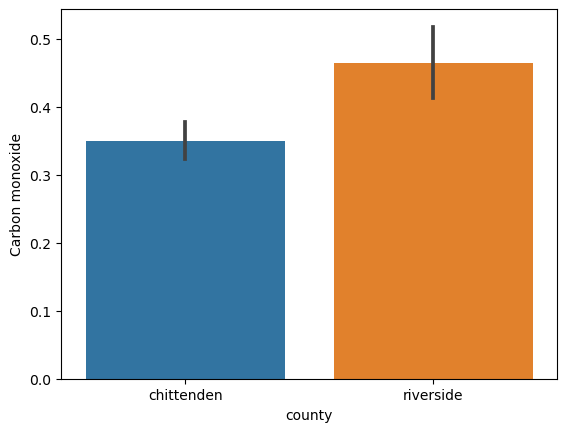

In [76]:
sns.barplot(data= chit_river, x='county', y=chit_river['Carbon monoxide']);

#### 2. Nitrogen Dioxide

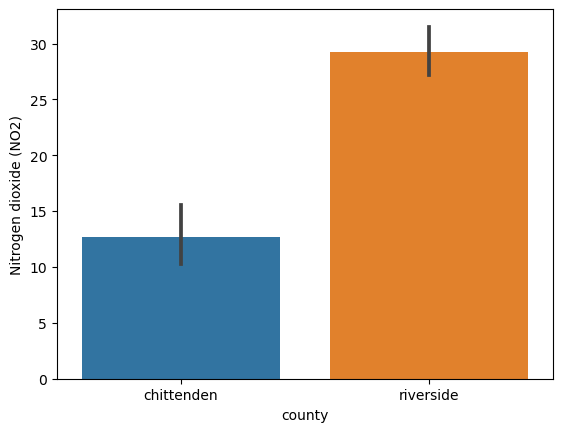

In [78]:
sns.barplot(data= chit_river, x='county', y=chit_river['Nitrogen dioxide (NO2)']);

#### 3. Ozone

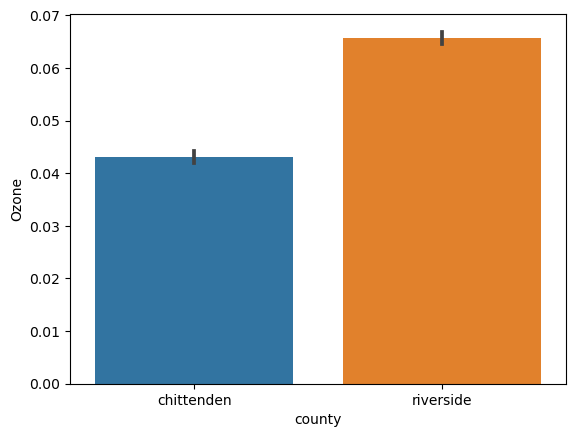

In [79]:
sns.barplot(data= chit_river, x='county', y=chit_river['Ozone']);

#### 4. PM 10 Concentrations

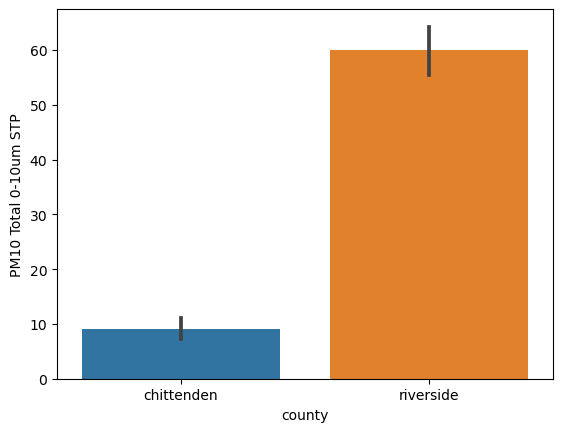

In [73]:
sns.barplot(data= chit_river, x='county', y=chit_river['PM10 Total 0-10um STP']);

#### 5. PM2.5 Concentrations

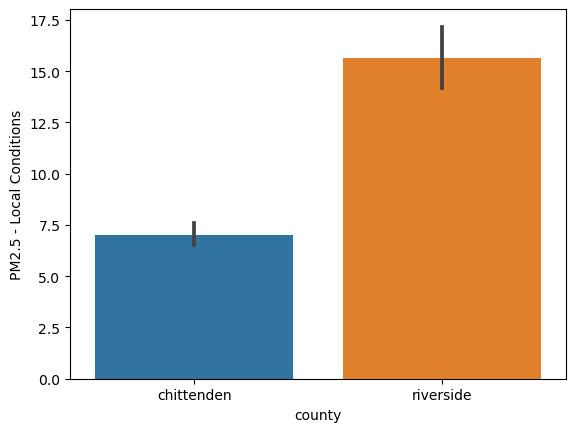

In [80]:
sns.barplot(data= chit_river, x='county', y=chit_river['PM2.5 - Local Conditions']);

#### 6. Pct Low Births

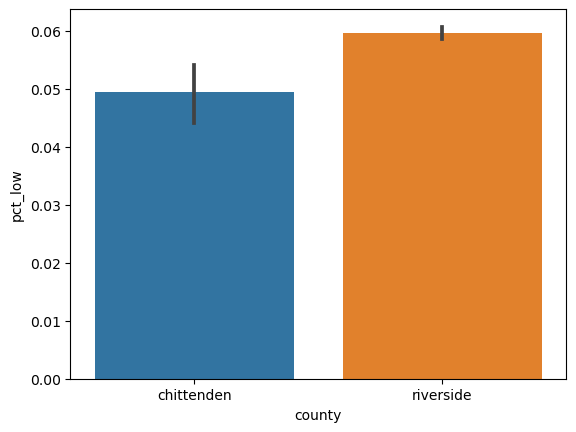

In [72]:
sns.barplot(data = chit_river, x = 'county', y='pct_low');

In [81]:
chittenden.pct_low.mean()

0.049416666666666664

In [82]:
riverside.pct_low.mean()

0.059666666666666666

### Discussion

From the visualiations, it becomes clear that the average concentrations of all of the pollutants assessed between years 2006 - 2020 is higher in Riverside than in Chittenden. 

Additionally, we can see that the mean percent of low birth weights is higher in Riverside than in Chittenden- a difference of more than 1%.

This could suggest that prenatal exposure to air pollutants does contribute to low birth weight - although both counties have an average percentage of low birth weights that is lower than the national average of 8.7%, and the current dataset average of 6.7%.

As this is informative, similar comparison visualizations of the high rate of low birth weight cases (1) and not high rate of low birth rate cases (0) will be prepared below.

## Visualizations - High Rate versus non-High Rate of Low Birth Weight 

#### 1. Carbon Monoxide

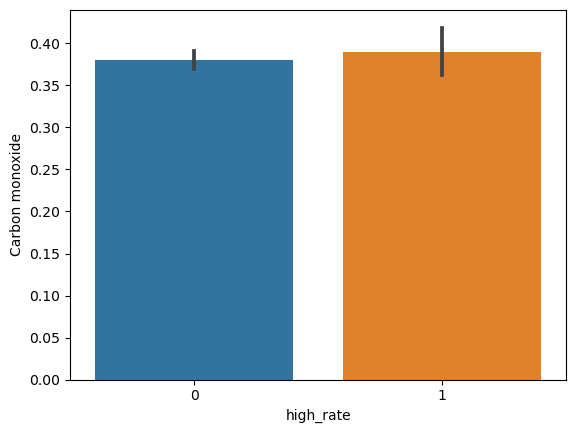

In [88]:
sns.barplot(data= aqs, x='high_rate', y=aqs['Carbon monoxide']);

#### 2. Nitrogen Dioxide

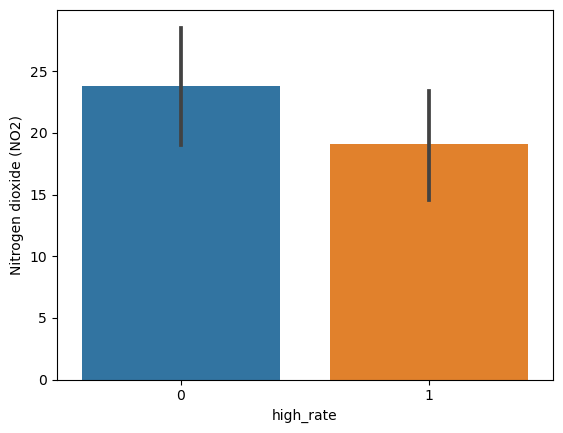

In [89]:
sns.barplot(data= aqs, x='high_rate', y=chit_river['Nitrogen dioxide (NO2)']);

#### 3. Ozone

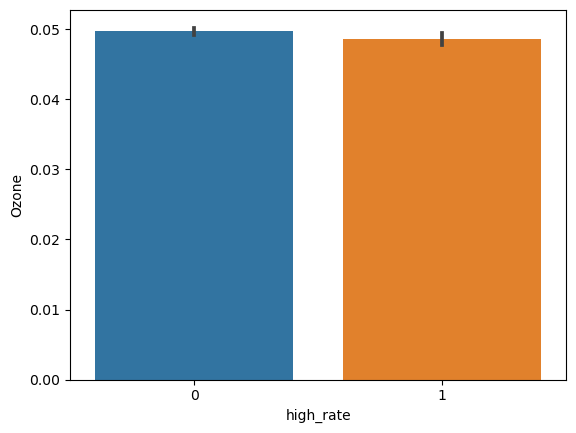

In [90]:
sns.barplot(data= aqs, x='high_rate', y=aqs['Ozone']);

#### 4. PM10 Concentrations

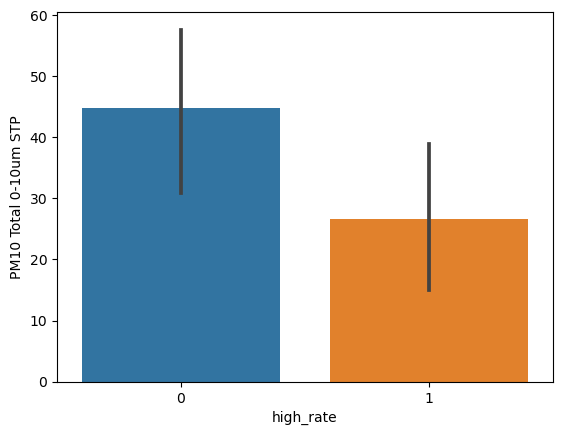

In [91]:
sns.barplot(data= aqs, x='high_rate', y=chit_river['PM10 Total 0-10um STP']);

#### 5. PM 2.5 Concentrations

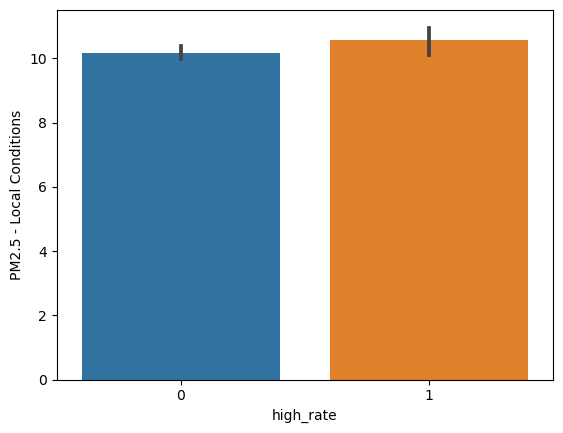

In [92]:
sns.barplot(data= aqs, x='high_rate', y=aqs['PM2.5 - Local Conditions']);

#### 6. Pct Low Birth Weight

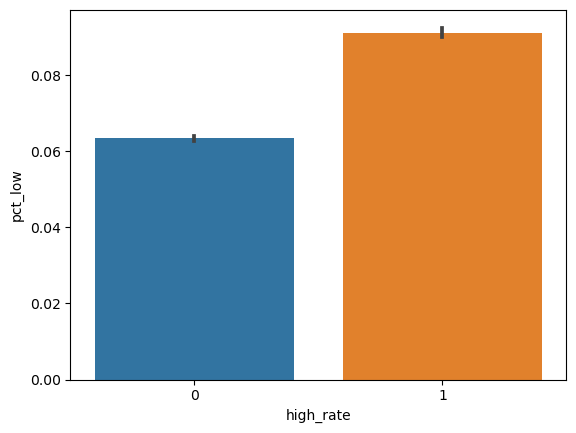

In [93]:
sns.barplot(data = aqs, x = 'high_rate', y='pct_low');

In [94]:
aqs.groupby('high_rate')['pct_low'].mean()

high_rate
0    0.063405
1    0.091146
Name: pct_low, dtype: float64

In [97]:
aqs.groupby('high_rate')['pct_low'].median()

high_rate
0    0.063
1    0.090
Name: pct_low, dtype: float64

In [101]:
aqs.high_rate.value_counts(normalize = True)

0    0.878458
1    0.121542
Name: high_rate, dtype: float64

### Discussion

When comparing the high rate versus not high rate low birth weight groups, it appears that those with high rate (defined as > 8.7%) typically had lower or similar pollutant values than the not high rate group, which is not the anticipated finding.

This may be due to the relatively wide variety of counties, years, and exposure levels that are within the not high rate group, as it comprises 87.8% of the dataset.

Still, we may be able to create a model that effectively distinguishes between the two groups. This will occur in the next notebook.